In [ ]:
import pandas as pd

# Load your labeled dataset
df = pd.read_csv('/content/fake reviews dataset.csv')  # Update path if needed

# Rename columns for clarity
df.rename(columns={'text_': 'review'}, inplace=True)

# Encode labels: 'CG' = 1 (real), 'OR' = 0 (fake)
df['label'] = df['label'].map({'CG': 1, 'OR': 0})

# Drop any rows with missing values (just in case)
df.dropna(subset=['review', 'label'], inplace=True)

# Preview
df[['review', 'label']].head()


,review,label
0,"Love this! Well made, sturdy, and very comfor...",1
1,"love it, a great upgrade from the original. I...",1
2,This pillow saved my back. I love the look and...,1
3,"Missing information on how to use it, but it i...",1
4,Very nice set. Good quality. We have had the s...,1


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving fake reviews dataset.csv to fake reviews dataset.csv


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def clean_text(text):
    text = str(text).lower()
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)
df[['review', 'cleaned_review']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,review,cleaned_review
0,"Love this! Well made, sturdy, and very comfor...",love well made sturdy comfortable love pretty
1,"love it, a great upgrade from the original. I...",love great upgrade original mine couple year
2,This pillow saved my back. I love the look and...,pillow saved back love look feel pillow
3,"Missing information on how to use it, but it i...",missing information use great product price
4,Very nice set. Good quality. We have had the s...,nice set good quality set two month


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_review']).toarray()
y = df['label']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


XGBoost

In [ ]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" Classification Report:\n", classification_report(y_test, y_pred))


 Accuracy: 0.8486459750216396
 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      4044
           1       0.87      0.82      0.84      4043

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087



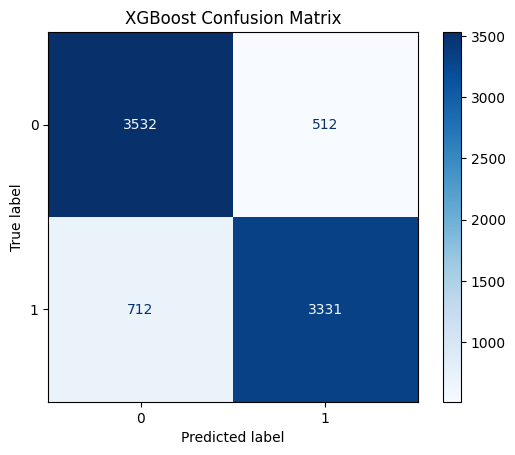

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

DNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.7766 - loss: 0.4493 - val_accuracy: 0.8686 - val_loss: 0.2976
Epoch 2/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9116 - loss: 0.2167 - val_accuracy: 0.8638 - val_loss: 0.3059
Epoch 3/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9388 - loss: 0.1559 - val_accuracy: 0.8669 - val_loss: 0.3389
Epoch 4/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9689 - loss: 0.0883 - val_accuracy: 0.8683 - val_loss: 0.4008
Epoch 5/5
405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9840 - loss: 0.0480 - val_accuracy: 0.8675 - val_loss: 0.4949


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(" DNN Test Accuracy:", accuracy)


253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8796 - loss: 0.4471
 DNN Test Accuracy: 0.8798071146011353


In [ ]:
from sklearn.metrics import classification_report

# Predict (threshold = 0.5)
y_pred_dnn = (model.predict(X_test) > 0.5).astype("int32")

print("DNN Classification Report:\n", classification_report(y_test, y_pred_dnn))

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
DNN Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4044
           1       0.87      0.89      0.88      4043

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



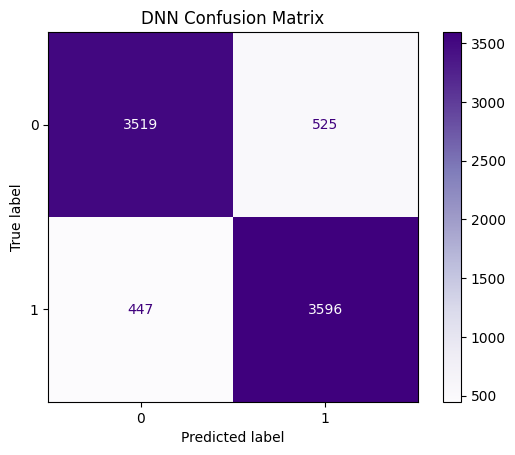

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dnn, cmap='Purples')
plt.title("DNN Confusion Matrix")
plt.show()

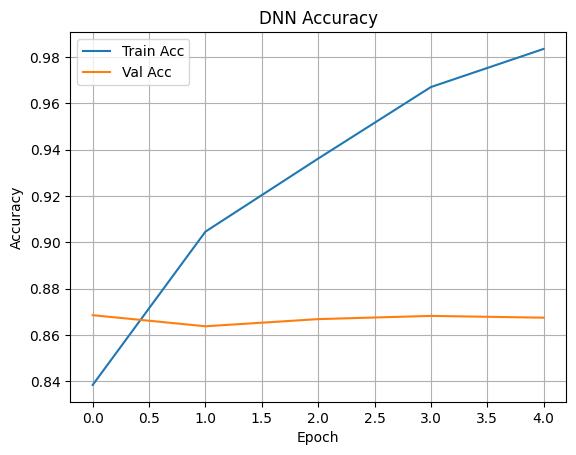

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("DNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

BERT Model

In [ ]:
!pip install transformers datasets accelerate --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df = pd.read_csv('/content/fake reviews dataset.csv')
df = df.rename(columns={'text_': 'review', 'label': 'label'})
df['label'] = df['label'].map({'CG': 1, 'OR': 0})
df = df[['review', 'label']].dropna().sample(frac=1).reset_index(drop=True)
df.head()


,review,label
0,"FAR FARRR FARRRRR From ""Professional"". I have...",1
1,the movies is very enjoyable and has the chemi...,1
2,Great quality but I thought it would be a litt...,0
3,The power of love is the sweetest and craziest...,0
4,Works fine. Installation was easy. The only ...,1


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokens = tokenizer(
    list(df['review']),
    max_length=256,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']
labels = df['label'].values


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(input_ids, attention_mask, torch.tensor(labels))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16)


In [ ]:
import torch.nn as nn
from transformers import BertModel

class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask=attention_mask, return_dict=False)
        x = self.dropout(pooled_output)
        return torch.sigmoid(self.linear(x))


In [ ]:
model = BERTClassifier().cuda()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training Loop
for epoch in range(2):
    model.train()
    total_loss = 0
    for batch in train_dl:
        input_ids, attn_mask, labels = [x.cuda() for x in batch]
        outputs = model(input_ids, attn_mask).squeeze()
        loss = loss_fn(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dl):.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Loss: 0.1119
Epoch 2, Loss: 0.0330


In [ ]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_dl:
        input_ids, attn_mask, labels = [x.cuda() for x in batch]
        outputs = model(input_ids, attn_mask).squeeze()
        preds = (outputs > 0.5).int().cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4013
           1       0.98      0.99      0.98      4074

    accuracy                           0.98      8087
   macro avg       0.98      0.98      0.98      8087
weighted avg       0.98      0.98      0.98      8087



In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def predict_review(review_text):
    model.eval()
    inputs = tokenizer(
        review_text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=256
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask).squeeze().item()

    label = "Real" if output > 0.5 else "Fake"
    confidence = output if output > 0.5 else 1 - output
    return label, round(confidence * 100, 2)

In [ ]:
review_1 = "This product is amazing! I'm very happy with the quality."
review_2 = "Worst product ever. Totally disappointed. Don’t waste your money."
review_3 = "I liked it. But something feels off. Seems too good to be true."
review_4 = "Absolutely love it! Fast shipping and great quality."

for r in [review_1, review_2, review_3, review_4]:
    label, conf = predict_review(r)
    print(f"Review: {r}\n→ Predicted: {label} (Confidence: {conf}%)\n")

Review: This product is amazing! I'm very happy with the quality.
→ Predicted: Real (Confidence: 97.62%)

Review: Worst product ever. Totally disappointed. Don’t waste your money.
→ Predicted: Fake (Confidence: 97.77%)

Review: I liked it. But something feels off. Seems too good to be true.
→ Predicted: Fake (Confidence: 99.94%)

Review: Absolutely love it! Fast shipping and great quality.
→ Predicted: Fake (Confidence: 99.47%)

